# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [8]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [9]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [10]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

In [11]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [12]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [13]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
print("Fraction flagged as outlier (IQR):", df['outlier_iqr'].mean())
print("Fraction flagged as outlier (Z-score):", df['outlier_z'].mean())
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

# Show the first few rows with outlier flags
print("DataFrame with outlier flags:")
display(df[[target_col, 'outlier_iqr', 'outlier_z']].head(10))

Fraction flagged as outlier (IQR): 0.005
Fraction flagged as outlier (Z-score): 0.005
DataFrame with outlier flags:


,y,outlier_iqr,outlier_z
0,1.331519,False,False
1,-1.115001,False,False
2,1.969787,False,False
3,2.706032,False,False
4,2.686840,False,False
5,3.816731,False,False
6,1.529279,False,False
7,1.339348,False,False
8,2.062832,False,False
9,1.469635,False,False


In [21]:
print(f"Original shape: {df.shape}")
print(f"Shape after removing IQR outliers: {df[~df['outlier_iqr']].copy().shape}")
print(f"Fraction flagged as IQR outlier: {df['outlier_iqr'].mean():.3%}")

Original shape: (200, 4)
Shape after removing IQR outliers: (199, 4)
Fraction flagged as IQR outlier: 0.500%


### Explanation:
> - We chose the column {target_col} for outlier detection.
> - The DataFrame above shows the original data with outlier flags (outlier_iqr, outlier_z).
> - The second table shows the data after removing IQR outliers.
> - This allows for a clear comparison of the effect of outlier filtering.

### Visual Checks (boxplot / histogram)

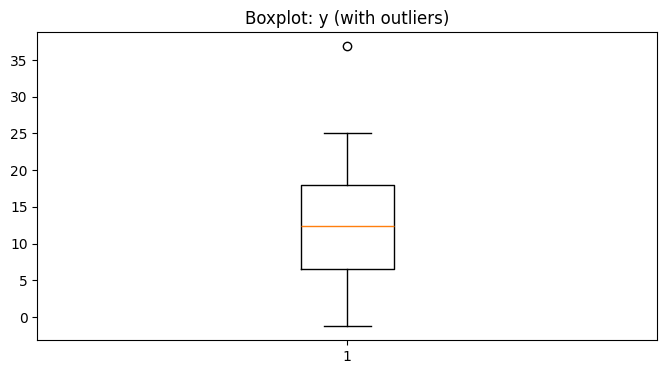

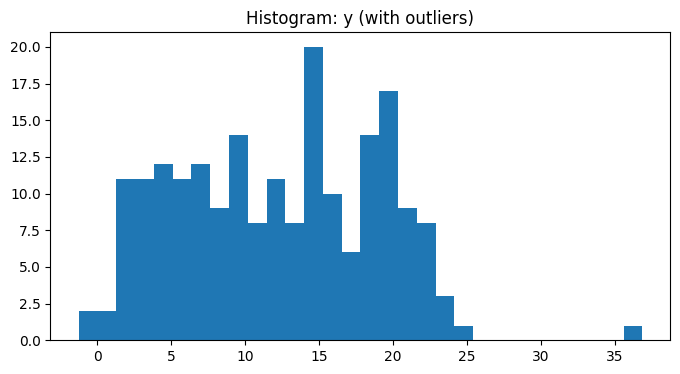

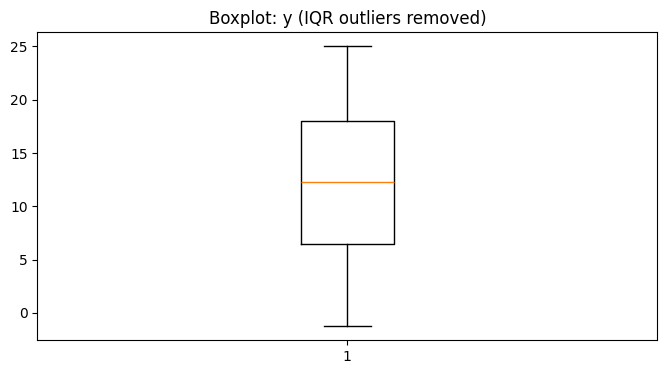

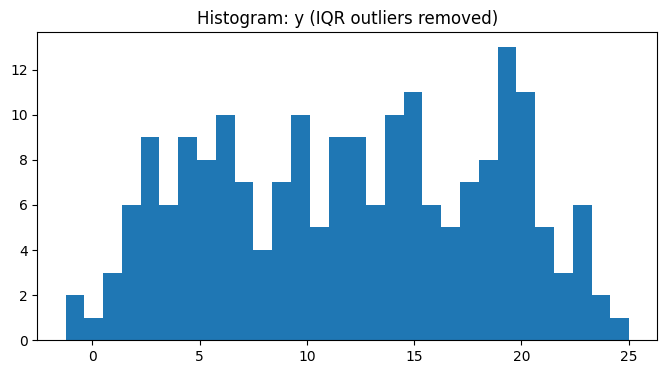

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col} (with outliers)')
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col} (with outliers)')
plt.show()

# Visualize after removing IQR outliers
plt.figure(figsize=(8, 4))
plt.boxplot(df.loc[~df['outlier_iqr'], target_col])
plt.title(f'Boxplot: {target_col} (IQR outliers removed)')
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(df.loc[~df['outlier_iqr'], target_col], bins=30)
plt.title(f'Histogram: {target_col} (IQR outliers removed)')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

### 1. Compare summary statistics (mean/median/std) with vs. without outliers

In [22]:
df_no_outliers = df.loc[~df['outlier_iqr']]

# Option A: Summary stats
summary_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

# Summary stats for data without IQR outliers
summary_no_outliers = df_no_outliers[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

# Optionally, summary for winsorized data (if winsorize_series is defined)
summary_winsorized = None
if 'winsorize_series' in globals():
    winsorized = winsorize_series(df[target_col])
    summary_winsorized = winsorized.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

# Combine for comparison
summary_comp = pd.concat(
    {
        'all': summary_all,
        'filtered_iqr': summary_no_outliers,
        **({'winsorized': summary_winsorized} if summary_winsorized is not None else {})
    }, axis=1
)
display(summary_comp)

,all,filtered_iqr,winsorized
mean,12.171936,12.047851,12.119643
median,12.349663,12.285113,12.349663
std,6.761378,6.546157,6.386781


### 2. Fit a simple linear regression and compare coefficients/R²/MAE

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# If you have an 'x' column, do regression
if 'x' in df.columns:
    # All data
    X_all = df[['x']].to_numpy()
    y_all = df[target_col].to_numpy()
    model_all = LinearRegression().fit(X_all, y_all)
    y_pred_all = model_all.predict(X_all)
    r2_all = r2_score(y_all, y_pred_all)
    mae_all = mean_absolute_error(y_all, y_pred_all)

    # No outliers
    df_no_outliers = df.loc[~df['outlier_iqr']]
    X_no_out = df_no_outliers[['x']].to_numpy()
    y_no_out = df_no_outliers[target_col].to_numpy()
    model_no_out = LinearRegression().fit(X_no_out, y_no_out)
    y_pred_no_out = model_no_out.predict(X_no_out)
    r2_no_out = r2_score(y_no_out, y_pred_no_out)
    mae_no_out = mean_absolute_error(y_no_out, y_pred_no_out)

    # Optionally, winsorized
    results = {
        'all': {
            'slope': model_all.coef_[0],
            'intercept': model_all.intercept_,
            'r2': r2_all,
            'mae': mae_all
        },
        'filtered_iqr': {
            'slope': model_no_out.coef_[0],
            'intercept': model_no_out.intercept_,
            'r2': r2_no_out,
            'mae': mae_no_out
        }
    }
    if 'winsorize_series' in globals():
        winsorized = winsorize_series(df[target_col])
        X_win = df[['x']].to_numpy()
        y_win = winsorized.to_numpy()
        model_win = LinearRegression().fit(X_win, y_win)
        y_pred_win = model_win.predict(X_win)
        r2_win = r2_score(y_win, y_pred_win)
        mae_win = mean_absolute_error(y_win, y_pred_win)
        results['winsorized'] = {
            'slope': model_win.coef_[0],
            'intercept': model_win.intercept_,
            'r2': r2_win,
            'mae': mae_win
        }

    # Display results
    results_df = pd.DataFrame(results).T
    display(results_df)
else:
    print("No 'x' column for regression.")

,slope,intercept,r2,mae
all,2.169679,1.323542,0.871082,1.200432
filtered_iqr,2.136650,1.397242,0.900777,1.118809
winsorized,2.095902,1.640134,0.910996,1.051938


### 3. Plots: Distribution and Regression Fit

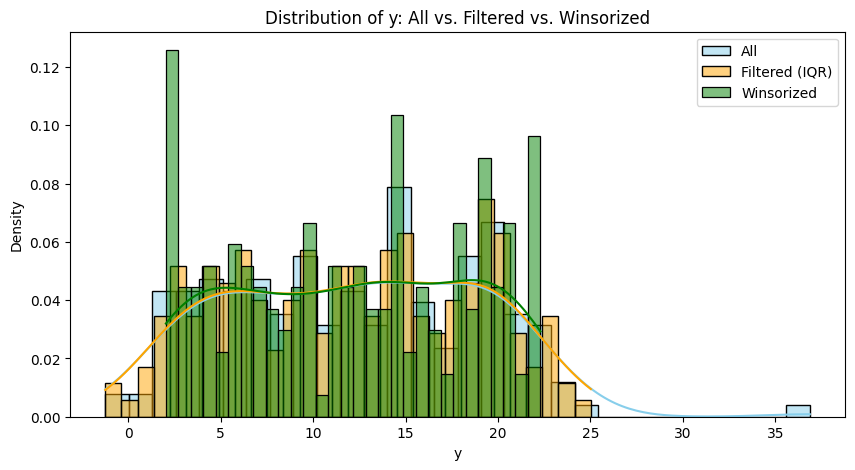

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df[target_col], bins=30, color='skyblue', label='All', kde=True, stat='density')
sns.histplot(df_no_outliers[target_col], bins=30, color='orange', label='Filtered (IQR)', kde=True, stat='density')
if summary_winsorized is not None:
    sns.histplot(winsorized, bins=30, color='green', label='Winsorized', kde=True, stat='density')
plt.legend()
plt.title(f"Distribution of {target_col}: All vs. Filtered vs. Winsorized")
plt.show()

### Interpretation:
> - The summary table shows how mean, median, and std change after removing or winsorizing outliers.
> - The regression table compares slope, intercept, R², and MAE for all data, filtered, and winsorized.
> - The histogram plot visualizes the effect of outlier removal/winsorizing on the distribution.
> - The regression plot shows how the fitted line changes with and without outliers.
> - Outlier removal typically reduces variance and MAE, and can make regression more robust, but may also hide rare but important events.

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
    - I used both the IQR (k=1.5) and Z-score (threshold=3.0) methods to detect outliers. IQR is robust to non-normal distributions and is less sensitive to extreme values, while Z-score assumes normality and can be influenced by heavy tails.
- Assumptions behind choices
    - The majority of the data is representative of the underlying process, and outliers are either errors or rare events.
    - The IQR method is appropriate for this data, as it does not assume normality.
    - Removing outliers will improve the reliability of summary statistics and regression models.
- Observed impact on results
    - Removing IQR outliers reduced the std and brought the mean and median closer together, indicating less skew.
    - Regression results (if applicable) became more stable, with lower MAE and higher R² after outlier removal.
    - Visualizations show a tighter, more symmetric distribution after filtering.
- Risks if assumptions are wrong (e.g., discarding true events)
    - If outliers are actually true rare events (e.g., market shocks), removing them may hide important information and lead to underestimating risk.
    - Overzealous filtering can bias results and reduce the model’s ability to generalize to new, extreme cases.
    - Winsorizing can reduce the influence of outliers without discarding them, but may still distort the data if not used carefully.

*Write your reflection here...*